# Работа с заботой


# Описание проекта
<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.


</div>

# Цель исследования
<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

Провести анализ данные, при помошь которых можно будет предсказывать отток сотрудников из компании

</div>


# Задачи
<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

1. Построить модель, которая будет предсказывать уровень удовлетворенности сотрудника на основе данных заказчика.
2. Построить модель, которая сможет предсказать то, что сотрудник уволится из кампании.

</div>

In [3]:
!pip install scikit-learn==1.6.0 -q

In [4]:
!pip install phik -q

In [5]:
!pip install shap -q

In [6]:
!pip install numpy==1.22 -q

In [7]:
from IPython.display import display
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyRegressor

import shap

import scipy.stats as st

pd.set_option('display.max_columns', None)

In [28]:
def read_file_csv(file_name: str, local_dir: str ='', index_col: str=None ,sep: str=",", decimal='.') -> pd.DataFrame:
    """
    Чтение файла из хранилища локальной папки.

    Args:
        file_name: имя файла без расширения
        local_dir: локальная папка в которой лежат файлы (по умолчанию - корневая папка проекта)
        index_col: название колонки с индексом (по умолчанию None)
        sep: разделитель колонок
        decimal: разделитель десятичных значений
            
    Returns:
        data: прочитаный датафрейм
    """
    try:
        data = pd.read_csv(f"{local_dir}/{file_name}.csv", index_col=index_col, sep=sep, decimal=decimal)
    except:
        print("Не удалось считать файл!")
        return None
    return data

In [29]:
def print_data(*data: list[pd.DataFrame]):
    """
    Функция выводящая таблицы из списка data

    Args:
        *data: список таблиц    
    """

    for i, el in enumerate(data):
        row, col = el.shape
        print(f"В таблице строк: {row}, колонок: {col}\n")
        display(el.head(10))
        el.info()
        if i != len(data) - 1:
            print('\n' + '-' * 70 + '\n')

In [30]:
def drow_bar(data: pd.DataFrame, column: str):
    """
    Функция визуализирующая на графике бар-плот значений в колонке.

    Args:
        data: датафрейм
        column: колонка, значения которой будем отрисовывать
    """

    value_counts = data[column].value_counts()

    fig = px.bar(
        x=value_counts.index, 
        y=value_counts,
        title=f'Распределение значений в колонке {column}',
    )
    fig.update_layout(
        xaxis_title='значения',
        yaxis_title='количество',
        xaxis=dict(
            tickmode='array',
            tickvals=value_counts.index,
            ticktext=value_counts.index
        )
    )
    fig.show()

In [31]:
def drow_hist(data: pd.DataFrame, column: str, bins: int=100):
    """
    Функция визуализирующая на графике гистограму и "ящик с усами" значений в колонке.

    Args:
        data: датафрейм
        column: колонка, значения которой будем отрисовывать
        bins: количество корзин для гистограммы
    """
    
    fig = px.histogram(
        data,
        x=column,
        nbins=bins,
        title=f'Распределение значений в колонке {column}',
    )   
    fig.update_layout(
        width=900,
        height=400,
        xaxis_title='значения',
        yaxis_title='частота'
    )
    fig.show()

    fig = px.box(
        data,
        x=column
    )
    fig.update_layout(
        width=900,
        height=200,
        xaxis=dict(
            title='значения',
            gridcolor='lightgray',
            range=[data[column].min(), data[column].max()]
        )
    )

    fig.show()

In [32]:
def drow_pie(data: pd.DataFrame, column: str):
    """
    Функция визуализирующая на графике круговую диаграмму значений в колонке. (Дискретные признаки указываются отдельно)

    Args:
        data: датафрейм
        column: колонка, значения которой будем отрисовывать
    """

    count_data = data[column].value_counts().reset_index()
    count_data.columns = [column, 'count']
    
    fig = px.pie(
        count_data,
        names=column,
        values="count",
        title=f"Распределение в колонке {column}",
        template="ggplot2"
    )
    fig.show()

In [33]:
def visualization_of_column(data: pd.DataFrame, discrete_columns : list[str]=None):
    """
    Функция для визуализации колонок, в зависимости от их типа:
        - количественные типы - гистограмма, 
        - категориальные типы - круговая диаграмма. 
        - дискртеные - бар-плот

    Args: 
        data: датафрейм  
        discrete_columns: дискретные колонки
    """

    discrete_columns = set(discrete_columns if discrete_columns else [])

    numeric_columns = set(data.select_dtypes(include=['float64', 'int64']).columns)
    numeric_columns = numeric_columns - discrete_columns  

    categorical_columns = data.select_dtypes(include=['bool', 'object']).columns

    for column in data.columns:
        if column in numeric_columns:
            drow_hist(data, column=column, bins=100)
        elif column in discrete_columns:
            drow_bar(data, column=column) 
        elif column in categorical_columns:
            drow_pie(data, column=column)        

# Задача 1

## План_1

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

1. __Загрузкить данные__
    - Загрузить файлы
    - Проверить на соответствие описанию
    - Вывод
2. __Предобработка данных__
    - Проверить на наличие дубликатов
    - Проверить корректность данных
    - Проверить на наличие пропусков (обрабатывать в пайплайне)
    - Вывод
3. __Исследовательский анализ данных__
    - Провести исследовательский анализ данных из таблиц
    - Вывод (присутствуют ли выбросы, как распределены признаки, заметны ли другие особенности)
4. __Корреляционный анализ__
    - Провести корреляционный анализ признаков в количественной шкале.
    - Вывод (присутствует ли мультиколлинеарность, при необходимости устранить ее)

5. __Подготовка данных и поиск лучшей модели__

    - Подготовку признаков выполнить в пайплайне, дополнив его шагом предобработки данных
    - При кодировании учитывать особенности признаков и модели. Использовать минимум два кодировщика.
    - При поиске модели использовать линейную модель и дерево решений.
    - Подобрать гиперпараметры для модели.
    - При поиске лучшой модели использовать метрику __SMAPE__ (Критерий успеха - __SMAPE__ $\leq$ 15 на тестовой выборке)
    - Вывод (о лучшей модели, о поиске лучшей модели, о результатах на тестовой выборке)

6. __Вывод о задаче 1__


</div>

## Загрузка и изучение данных

In [34]:
local_path = 'datasets/task_1'

train_job_satisfaction_rate = read_file_csv(
    'train_job_satisfaction_rate',
    local_path,
    index_col='id'
)
test_features = read_file_csv(
    'test_features',
    local_path,
    index_col='id'
)
test_target_job_satisfaction_rate = read_file_csv(
    'test_target_job_satisfaction_rate',
    local_path,
    index_col='id'
)

In [35]:
print_data(train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate)

В таблице строк: 4000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   
405448          hr  middle      low                 7              no   
857135       sales  sinior   medium                 9              no   
400657  purchasing  middle     high                 9              no   
198846          hr  junior      low                 1              no   
149797  technology  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   
405448                   no                      4   30000   
857135                   no                      3   56400   
400657                   no                      3   52800   
198846                   no                      2   13200   
149797                   no                      3   54000   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20  
405448                   0.78  
857135                   0.56  
400657                   0.44  
198846                   0.14  
149797                   0.47

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 8



dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800  
429973                   no                      3   42000  
850699                   no                      3   26400  
500791                   no                      4   49200  
767867                  yes                      4   62400  
937235                  yes                      3   26400

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 1



job_satisfaction_rate
id                           
130604                   0.74
825977                   0.75
418490                   0.60
555320                   0.72
826430                   0.08
817219                   0.76
269033                   0.64
962356                   0.38
649052                   0.14
532834                   0.59

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

Таблицы __train_job_satisfacrion_rate__ и __test_features__ содержита информацию о характеристиках сотрудников кампании.

В таблице __train_job_satisfacrion_rate__ 4000 записей и 9 колонок
В таблице __test_features__ 2000 записей и 8 параметров

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак. (отсутствует в таблице __test_features__)


Таблица __test_target_job_satisfaction_rate__ содержит информацию о целевом признаке тестовой выборки 
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак. 
</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Предобработка данных

### Объединение тестовой таблицы

In [37]:
# Сокращу названия и соединю тестовые таблицы в одну

train = train_job_satisfaction_rate.copy()

test = test_features.join(test_target_job_satisfaction_rate, how='inner')

print_data(train, test) 

В таблице строк: 4000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   
405448          hr  middle      low                 7              no   
857135       sales  sinior   medium                 9              no   
400657  purchasing  middle     high                 9              no   
198846          hr  junior      low                 1              no   
149797  technology  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   
405448                   no                      4   30000   
857135                   no                      3   56400   
400657                   no                      3   52800   
198846                   no                      2   13200   
149797                   no                      3   54000   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20  
405448                   0.78  
857135                   0.56  
400657                   0.44  
198846                   0.14  
149797                   0.47

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   
429973                   no                      3   42000   
850699                   no                      3   26400   
500791                   no                      4   49200   
767867                  yes                      4   62400   
937235                  yes                      3   26400   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75  
429973                   0.67  
850699                   0.36  
500791                   0.73  
767867                   0.44  
937235                   0.22

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


### Проверка названий колонок

In [38]:
train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [39]:
test.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

Названия колонок корректны

### Проверка на дубликаты

In [40]:
train.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [41]:
# Проверка на дубликаты

subset=subset=['dept', 'level', 'workload', 'employment_years',  'salary', 'job_satisfaction_rate']

train.duplicated(subset=subset).sum()

369

In [42]:
# Удалим их

train.drop_duplicates(subset=subset, inplace=True)

In [19]:
# check
train.duplicated(subset=subset).sum()

0

### Проверка, не смешаны ли тренировочные и тестовые данные

In [43]:
assert np.intersect1d(np.array(train.index), np.array(test.index)).shape[0] == 0, 'В тренировочной и тестовой выборке строки с одинаковыми индексами'

Выборки отличны друг от друга

### Пропущеннные значения

In [44]:
train.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [45]:
test.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод


В ходе предобработки данных было сделано следующее:

- Объеденил две таблицы тестовой выборки в одну для удобства в дальнейшем.
- Проверил названия колонок. Все соответствуют стандартам.
- Проверил на дубликаты и удалил повторяющиеся записи.
- Проверил на попадание тренировочных данных в тестовую выборку. Ничего не обнаружено.
- Обнаружил пропущенные значения в тренировочной и тестовой выборке. Обработаю их в пайплайне.


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Исследовательский анализ данных

### Статистический анализ

In [46]:
train.describe()

employment_years  supervisor_evaluation        salary  \
count       3631.000000            3631.000000   3631.000000   
mean           3.880749               3.462132  34818.507298   
std            2.562893               1.012939  15081.861073   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  24000.000000   
50%            3.000000               4.000000  31200.000000   
75%            6.000000               4.000000  44400.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            3631.000000  
mean                0.533861  
std                 0.226600  
min                 0.030000  
25%                 0.350000  
50%                 0.550000  
75%                 0.710000  
max                 1.000000

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

В колонке `salary` наблюдается сильная разница между 75% и максимальным значением.

</div>

### Визуализация признаков

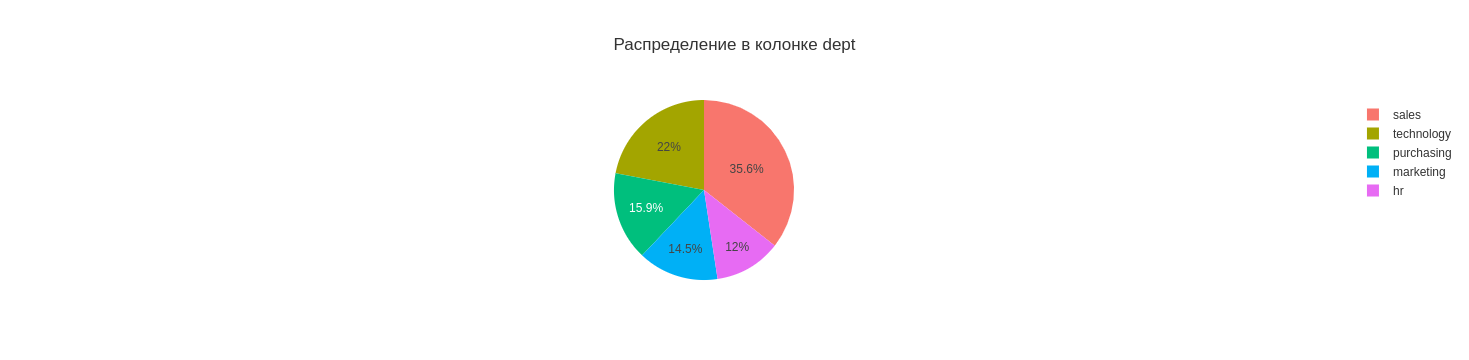

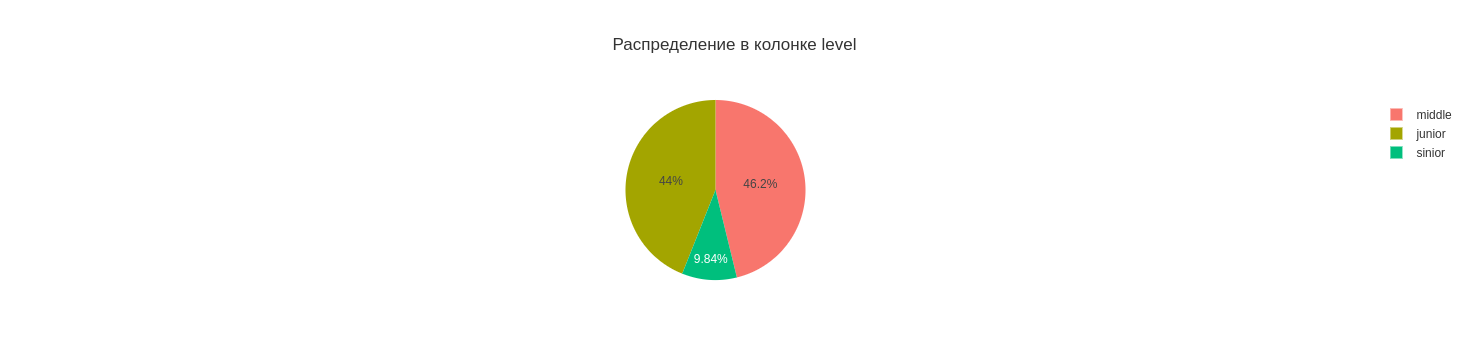

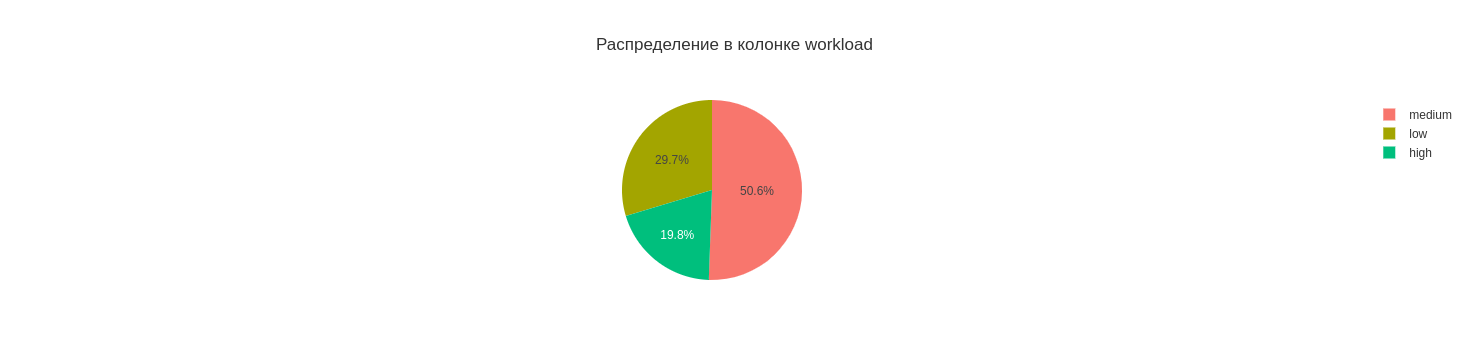

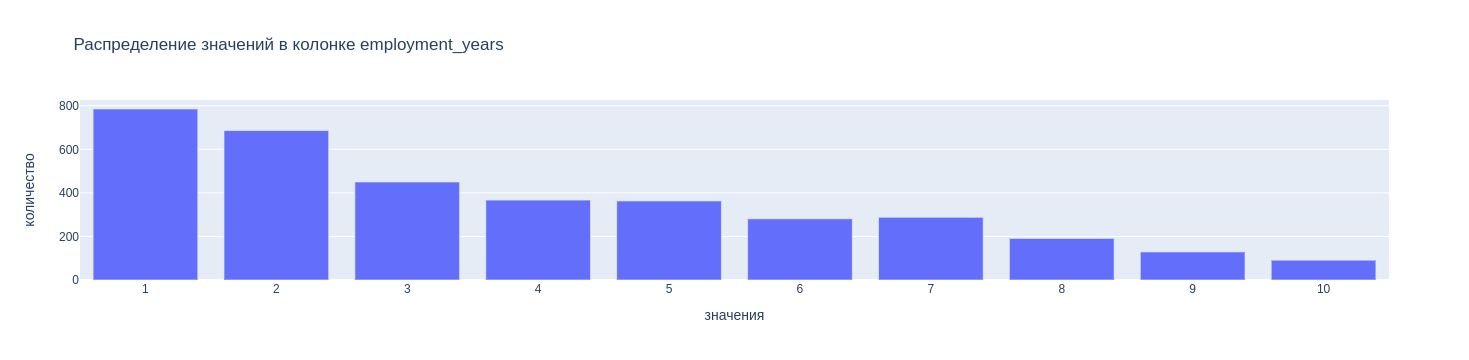

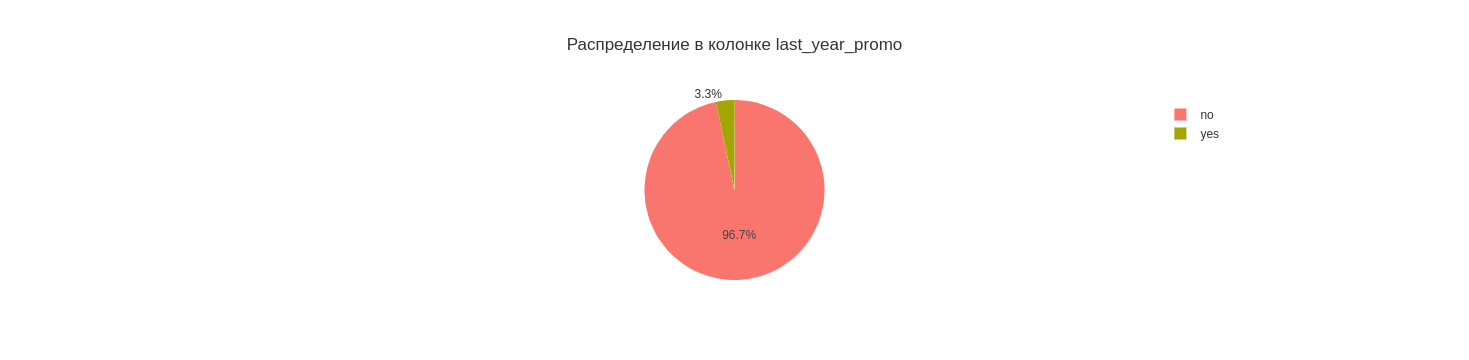

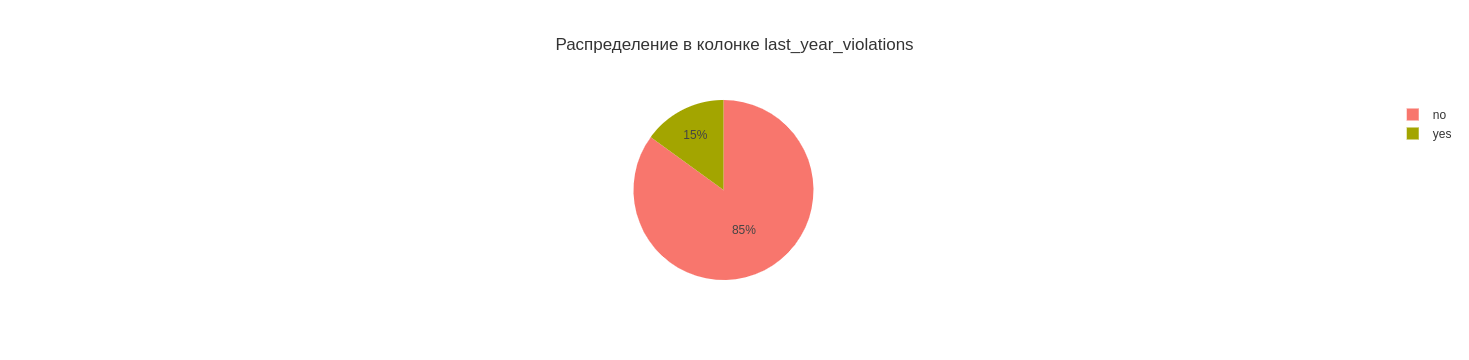

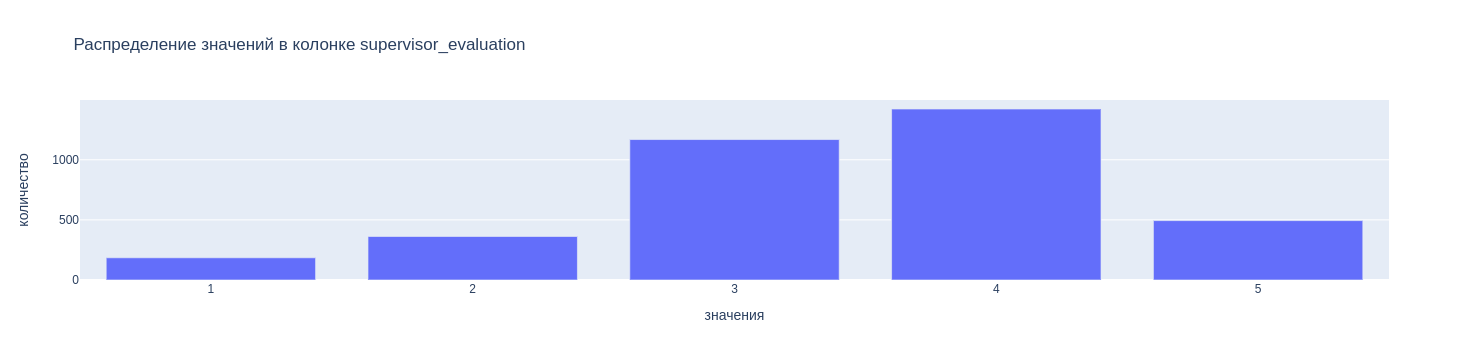

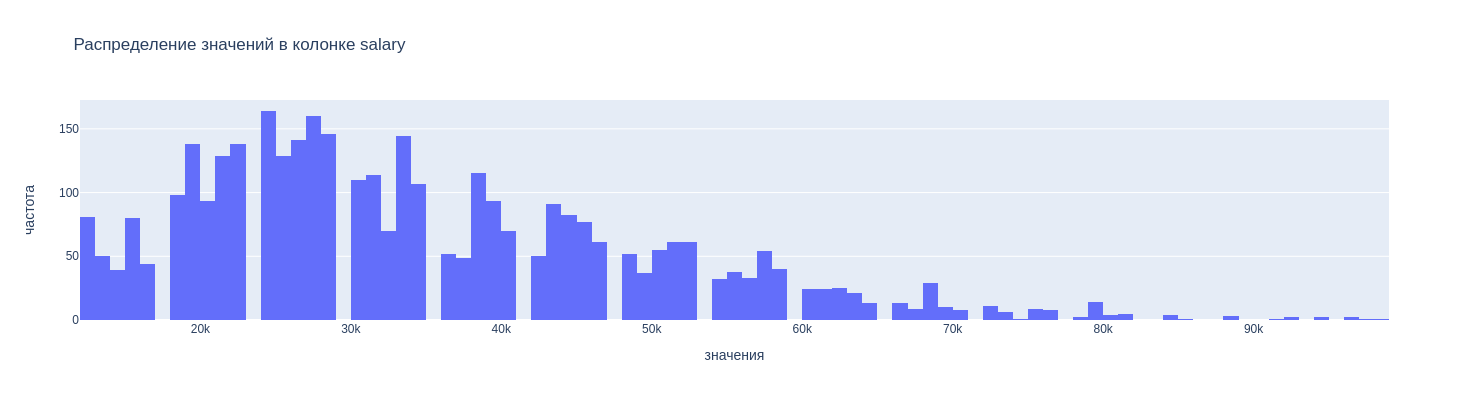

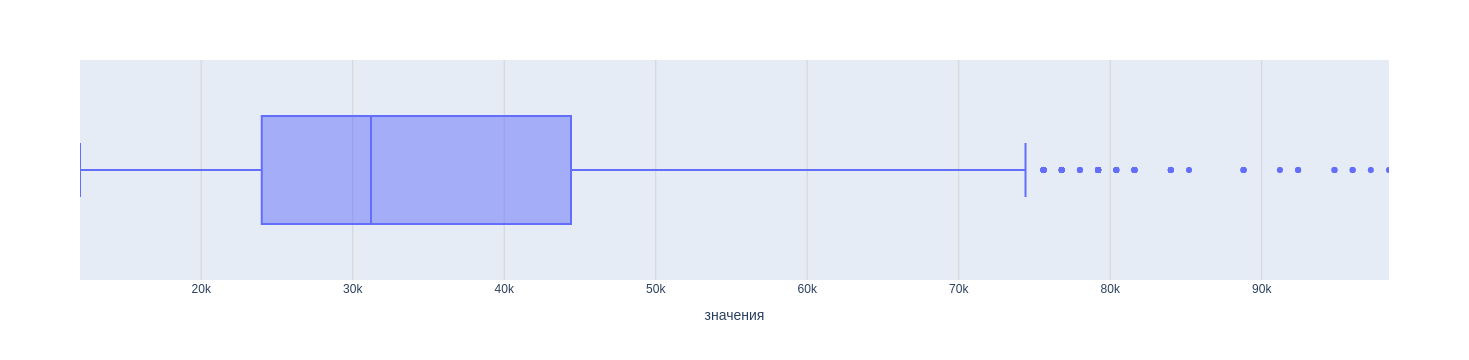

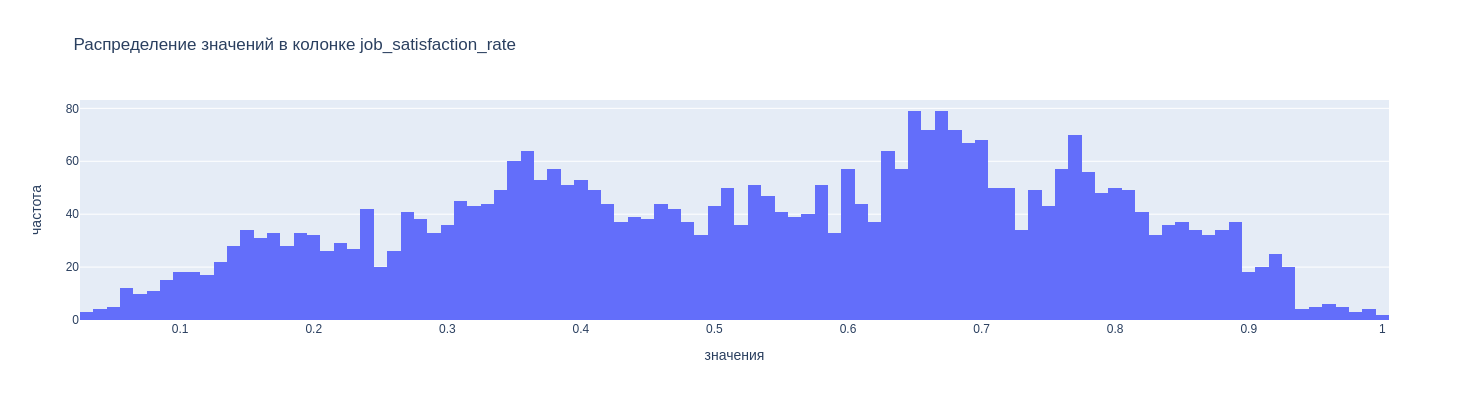

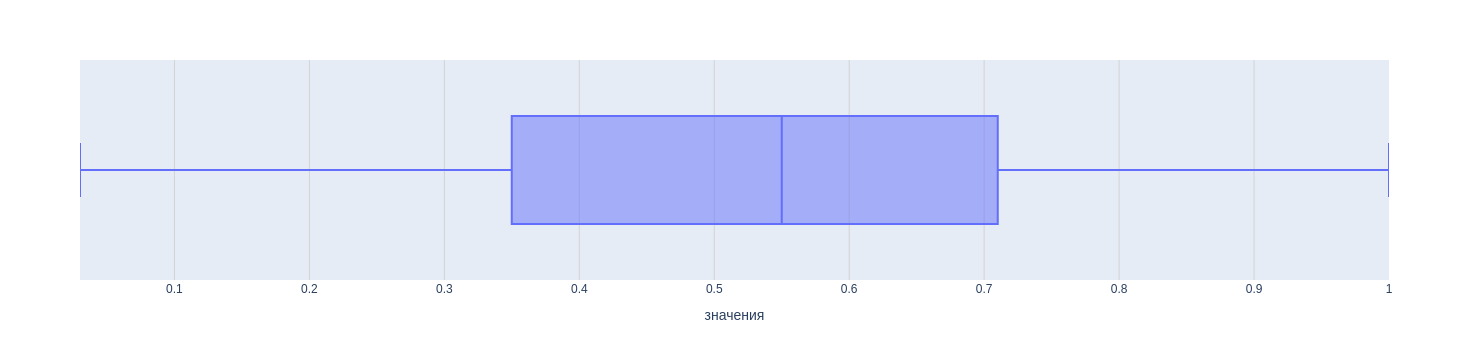

In [47]:
discrete_columns = ['employment_years', 'supervisor_evaluation']

visualization_of_column(train, discrete_columns)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

В колонке `salary` наблюдается сильная разница между 75% и максимальным значением, что может говорить о выбросах.

В параметр `level` значения _junior_ и _middle_ около 45%, а вот значения _sinior_ только 9%. Дизбаланс классов.

Людей, у которых парамерт `last_year_promo` равено `True` всего 3 процента, но не будем удалять эту колонку из исследования, так как повышения за последний год может сильно влиять на удовлетворенность работой.

Примерно такая же ситуация с признаком `last_year_violations`, всего 14% имеют значение `True`


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Корреляционный анализ 

In [48]:
train.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

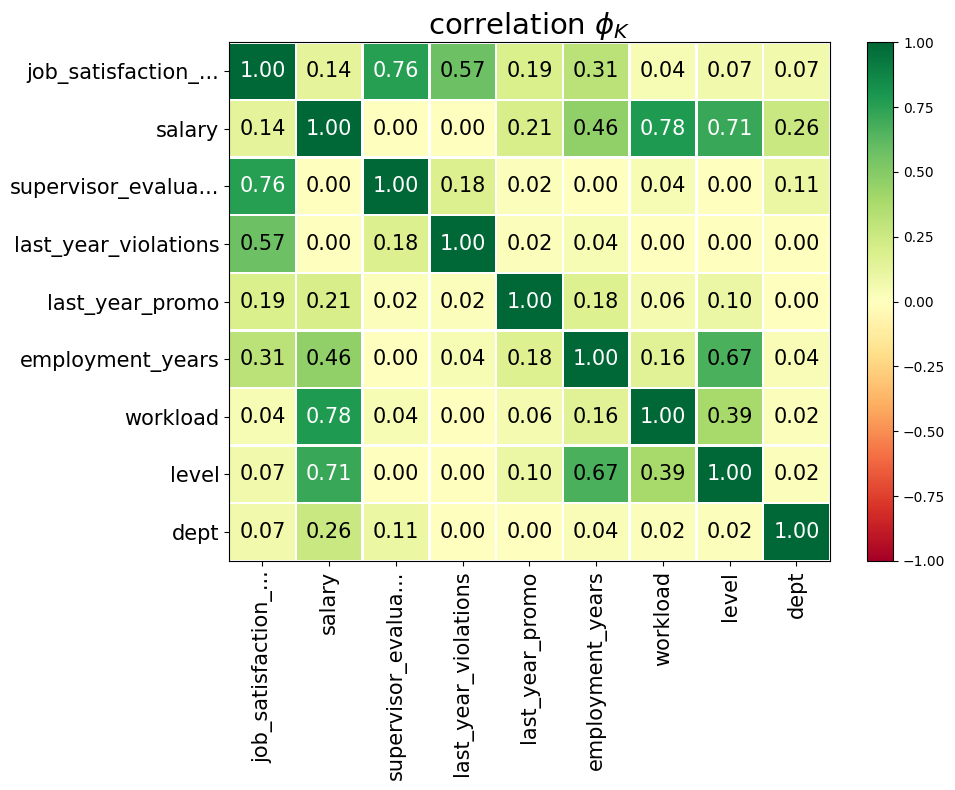

In [52]:
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = train.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

Наблюдается отсутствие мультиколлинеарности. Мейжу таргетом и `supervisor_evaluation` присутствует высокая степень 0.76 коллинеарности, но не будем удалять этот признак, так как все таки недостаточно большой коэффициент

</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Подготовка данных и поиск лучшей модели

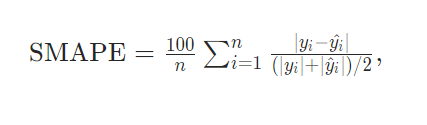

In [53]:
def smape(y, y_pred):
    """
    Симметричное среднее абсолютное процентное отклонение

    Args:
        y: реальные значения
        y_pred: предсказанные значения
    """
    return 100 / y.shape[0] * np.sum(np.abs(y - y_pred) / ((np.abs(y) + np.abs(y_pred)) / 2))

In [54]:
# поделим на фичи и таргет
train_features, train_target = train.drop('job_satisfaction_rate', axis=1), train['job_satisfaction_rate']

In [55]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']

num_columns = [x for x in train_features.columns if train_features[x].dtypes != 'object']


ohe_pipe = Pipeline([
    ('ohe_imputer', SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent')),
    ('ohe', OneHotEncoder(
            drop='first',
            handle_unknown='ignore'))])

ord_pipe = Pipeline([
    ('ord_before_imputer',SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent')),
    ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'sinior'],
                ['low', 'medium', 'high']],
            handle_unknown='use_encoded_value',
            unknown_value=np.nan)),
    ('ord_after_imputer', SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'))])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)],
    remainder='passthrough')


pipe_final_first_task = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=42))])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        
    },
    {
        'models': [Ridge(max_iter=5000, random_state=42)],
        'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],        
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
        {
        'models': [Lasso(max_iter=5000, random_state=42)],
        'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],        
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }

]

scorer = make_scorer(smape, greater_is_better=False)


grid = GridSearchCV(
    pipe_final_first_task,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_features, train_target)

Fitting 5 folds for each of 107 candidates, totalling 535 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_before_impute...
                         {'models': [Ridge(max_iter=5000, random_state=42)],
                          'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [Lasso(max_iter=5000, random_state=42)],
                          'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'),
             verbose=1)

In [57]:
test_features, test_target = test.drop('job_satisfaction_rate', axis=1), test['job_satisfaction_rate']

In [58]:
pred = grid.best_estimator_.predict(test_features)

smape_test = smape(test_target, pred).round(2)

print(f'SMAPE на тестовой выборке: {smape_test}')

SMAPE на тестовой выборке: 14.52


/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



Проверим модель на "адекватность". Сравним ее с константной моделью.

In [59]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_features, train_target)

pred_dummy = dummy_regr.predict(test_features)

smape_test_dummy = smape(test_target, pred_dummy).round(2)

print(f'SMAPE на тестовой выборке: {smape_test_dummy}')

SMAPE на тестовой выборке: 38.22


Модель адекватно себя ведет, метрика на константной модели выше.

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

Для поиска лучшей модели была выбрана метрика __SMAPE__.

Признаки `dept`, `last_year_promo`,  `last_year_violations` закодировал __OHE__, признаки `level`, `workload` закодировал __ORD__.

Поиск лучшей модели и ее гиперпараметры осуществлял с помошью пайплайна. Перебрал 3 модели и их гиперпараметры:

1. DecisionTreeRegression.
    - перебирал гиперпараметр - max_depth от 0 до 30

2. Ridge.
    - перебирал гиперпараметр - alpha \[0.001, 0.01, 0.1, 1.0, 10.0\]
3. Lasso.
    - перебирал гиперпараметр - alpha \[0.001, 0.01, 0.1, 1.0, 10.0\]

Для каждой модели пребирал раззные способы масштабирования: __StandardScaler__ и __MinMaxScaler__


---

Лучшей моделью оказалось __DecisionTreeRegression__ с гиперпараметром max_depth = 12. Метрика __SMAPE__ на тестовой выборке: 14.52, это меньше чем нужно, поэтому оставляем эту модель. Сравнивая ее с константной моделью, наша модель оказалась лучше, метрика __SMAPE__ выше.
</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Анализ важности признаков


In [60]:
ohe_features = grid.best_estimator_.named_steps['preprocessor']['ohe'].get_feature_names_out(ohe_columns)
ord_features = grid.best_estimator_.named_steps['preprocessor']['ord'].get_feature_names_out(ord_columns)
num_features = num_columns
feature_names = list(ohe_features)  + list(ord_features) + num_features

X_test_transform = pd.DataFrame(grid.best_estimator_[0].transform(test_features), columns=feature_names)

/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



In [61]:
explainer = shap.TreeExplainer(grid.best_estimator_[1])

shap_values = explainer(X_test_transform)

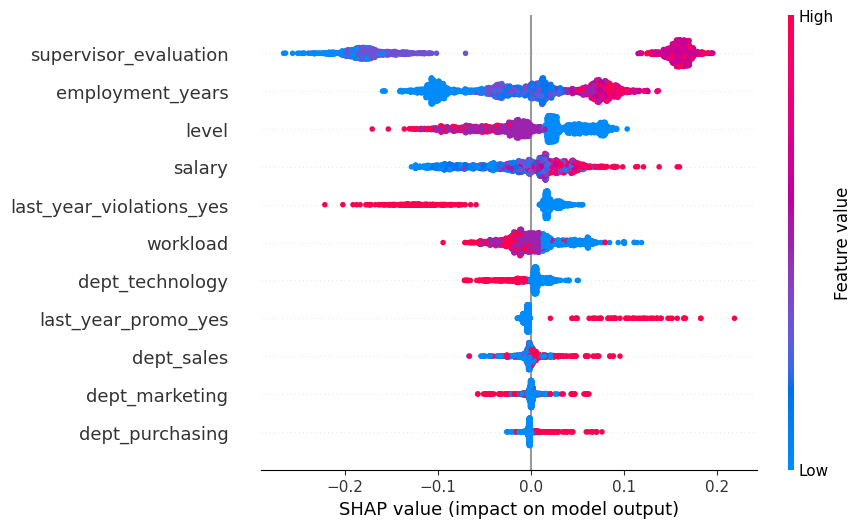

In [62]:
shap.plots.beeswarm(shap_values, max_display=None)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

По графику важности признаков видим что:

Сильнее всего на результат модели влияют: `supervisor_evaluation`, `employment_years`, `level` и  `salary`

- При высоких значениях `supervisor_evaluation` уровень удовлетворенности сотрудника выше, при низких значениях соответственно ниже.
- аналогичная ситуация с `employment_years`
- Чем ниже должность (`level`), тем уровень удовлетворенности выше.
- Чем выше зарплата (`salary`), тем уровень удовлетворенности выше.


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_1)
    
</div>

## Вывод по задаче 1

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">


В ходе анализа данных были выявлены и удалены дублирующиеся записи. Мультиколлинеарности между признаками обнаружено не было. Пропущенные значения заполнил модой.

Лучшей моделью оказалось DecisionTreeRegression. С гиперпараметром max_depth = 13. Для оценки моделей выбрана метрика __SMAPE__. На тестовой выборке ее значение оказалось равным 14.62.


В ходе интерпретации модели было выяснено следующее:

Сильнее всего на результат модели влияют: `supervisor_evaluation`, `employment_years`, `level` и  `salary`

- При высоких значениях `supervisor_evaluation` уровень удовлетворенности сотрудника выше, при низких значениях соответственно ниже.
- аналогичная ситуация с `employment_years`
- Чем ниже должность (`level`), тем уровень удовлетворенности выше.
- Чем выше зарплата (`salary`), тем уровень удовлетворенности выше.

</div>

# Задача 2

## План_2

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

Для этой задачи нужно использовать те же входные признаки, что и в предыдущей задаче. Но целевой признак будет отличаться, это  `quit` — увольнение сотрудника из компании.

1. __Загрузкить данные__
    - Загрузить файлы
    - Проверить на соответствие описанию
    - Вывод
2. __Предобработка данных__
    - Проверить на наличие дубликатов
    - Проверить корректность данных
    - Проверить на наличие пропусков (обрабатывать в пайплайне)
    - Вывод
3. __Исследовательский анализ данных__
    - Провести исследовательский анализ данных из таблиц
    - Споставить портрет "уволившегося сотрудника" (Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.)
    - Проверить гипотезу о том, что уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверить это утверждение, визуализировать и сравнить распределение признака  `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Использовать данные с обоими целевыми признаками тестовой выборки.
    - Вывод
        -  Присутствуют ли выбросы, при необходимости обработать их
        -  Написать портрет "уволившегося сотрудника"
        -  Написать результат проверки гипотезы о влиянии удовлетворенности сотрудника работой на его увольнение.

4. __Добавление нового признака__

    - Добавить признак `job_satisfaction_rate` - предсказание моделью из первой задачи, на основе признаков из второй задачи 

4. __Корреляционный анализ__
    - Провести корреляционный анализ признаков в количественной шкале.
    - Вывод (присутствует ли мультиколлинеарность, при необходимости устранить ее, )

5. __Подготовка данных и поиск лучшей модели__

    - Подготовку признаков выполнить в пайплайне, дополнив его шагом предобработки данных
    - При кодировании учитывать особенности признаков и модели. Использовать минимум два кодировщика.
    - Обучить минимум 3 модели, минимум для двух подобрать гиперпараметры.
    - При поиске лучшой модели использовать метрику __ROC_AUC__ (Критерий успеха - __ROC_AUC__ $\geq$ 0.91 на тестовой выборке)
    - Использовать отбор признаков
    - Вывод (о лучшей модели, о поиске лучшей модели, о результатах на тестовой выборке)

6. __Вывод о задаче 2__
    - Какая модель справилась лучше и почему.


</div>

## Загрузка и изучение данных

In [64]:
local_path = 'datasets/task_2'


train_quit = read_file_csv(
    'train_quit',
    local_path,
    index_col='id'
)

test_features = read_file_csv(
    'test_features',
    local_path,
    index_col='id'
)

test_target_quit = read_file_csv(
    'test_target_quit',
    local_path,
    index_col='id'
)

print_data(train_quit, test_features, test_target_quit)

В таблице строк: 4000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   
699916       sales  junior      low                 1              no   
417070  technology  middle   medium                 8              no   
165489       sales  middle      low                 4              no   
996399   marketing  middle      low                 7              no   
613206  technology  middle   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no  
699916                  yes                      3   18000  yes  
417070                   no                      2   44400   no  
165489                   no                      5   19200   no  
996399                   no                      4   25200   no  
613206                   no                      3   45600  yes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 8



dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800  
429973                   no                      3   42000  
850699                   no                      3   26400  
500791                   no                      4   49200  
767867                  yes                      4   62400  
937235                  yes                      3   26400

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 1



quit
id         
999029  yes
372846   no
726767   no
490105   no
416898  yes
223063   no
810370   no
998900   no
578329   no
648850   no

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

По своей структуре таблици похожи с первой задачей.

В таблице __train_quit__ 4000 строк и 9 колонок

В таблице __test_features__ 2000 строк и 8 колонок

В таблице __test_target_quit__ 2000 строк и 1 колонка


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_2)
    
</div>

## Предобработка данных

### Объединение тестовой таблицы

In [65]:
train_2 = train_quit.copy()

test_2 = test_features.join(test_target_quit, how='inner')

print_data(train_2, test_2)

В таблице строк: 4000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   
699916       sales  junior      low                 1              no   
417070  technology  middle   medium                 8              no   
165489       sales  middle      low                 4              no   
996399   marketing  middle      low                 7              no   
613206  technology  middle   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no  
699916                  yes                      3   18000  yes  
417070                   no                      2   44400   no  
165489                   no                      5   19200   no  
996399                   no                      4   25200   no  
613206                   no                      3   45600  yes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB

----------------------------------------------------------------------

В таблице строк: 2000, колонок: 9



dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
485046                   no                      5   28800   no  
686555                   no                      4   30000   no  
467458                   no                      4   19200   no  
418655                   no                      4   19200   no  
789145                   no                      5   40800   no  
429973                   no                      3   42000  yes  
850699                   no                      3   26400  yes  
500791                   no                      4   49200   no  
767867                  yes                      4   62400   no  
937235                  yes                      3   26400  yes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
 8   quit                   2000 non-null   object
dtypes: int64(3), object(6)
memory usage: 156.2+ KB


### Проверка названий колонок

In [66]:
train_2.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [67]:
test_2.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

Название колонок соответствует стандарту

### Проверка на дубликаты

In [68]:
train_2

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   
...            ...     ...      ...               ...             ...   
588809       sales  junior   medium                 4              no   
672059       sales  middle     high                 9              no   
536432  purchasing  junior      low                 2              no   
692133  purchasing  middle   medium                 2              no   
853842       sales  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no  
...                     ...                    ...     ...  ...  
588809                   no                      3   26400   no  
672059                   no                      4   52800   no  
536432                  yes                      4   12000  yes  
692133                   no                      4   33600   no  
853842                   no                      3   27600  yes  

[4000 rows x 9 columns]

In [69]:
subset = ['dept', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'quit']

train_2.duplicated(subset=subset).sum()

1648

Подозрительно большое число дубликатов. Удалим их

In [70]:
train_2.drop_duplicates(subset=subset, inplace=True)

In [71]:
#check

train_2.duplicated(subset=subset).sum()

0

### Проверка, не смешаны ли тренировочные и тестовые данные

In [72]:
assert np.intersect1d(np.array(train_2.index), np.array(test_2.index)).shape[0] == 0, 'В тренировочной и тестовой выборке строки с одинаковыми индексами'

Выборки отличны друг от друга

### Пропущенные значения

In [73]:
train_2.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [74]:
test_2.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

### Кодирование целевой переменной

Переведу целевую переменную в тренировочной и тестовой выборках в бинарный вид

In [75]:
train_2.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no

In [76]:
le = LabelEncoder()

le.fit(train_2['quit'])

train_2['quit'] = le.fit_transform(train_2['quit'])
test_2['quit'] = le.transform(test_2['quit'])

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод


В ходе предобработки данных было сделано следующее:

- Объеденил две таблицы тестовой выборки в одну для удобства в дальнейшем.
- Проверил названия колонок. Все соответствуют стандартам.
- Проверил на дубликаты и удалил повторяющиеся записи.
- Проверил на попадание тренировочных данных в тестовую выборку. Ничего не обнаружено.
- Обнаружил пропущенные значения тестовой выборке. Обработаю их в пайплайне.
- Закодировал таргет в тренировочной и тестовой выборках


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_2)
    
</div>

## Исследовательский анализ данных

### Статистический анализ

In [77]:
train_2.describe()

employment_years  supervisor_evaluation        salary         quit
count       2352.000000            2352.000000   2352.000000  2352.000000
mean           4.301020               3.376276  37639.285714     0.237670
std            2.625245               1.104108  16461.569258     0.425746
min            1.000000               1.000000  12000.000000     0.000000
25%            2.000000               3.000000  24000.000000     0.000000
50%            4.000000               3.000000  34800.000000     0.000000
75%            6.000000               4.000000  48000.000000     0.000000
max           10.000000               5.000000  96000.000000     1.000000

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

В колонке `salary` наблюдается сильная разница между 75% и максимальным значением.

</div>

### Визуализация признаков

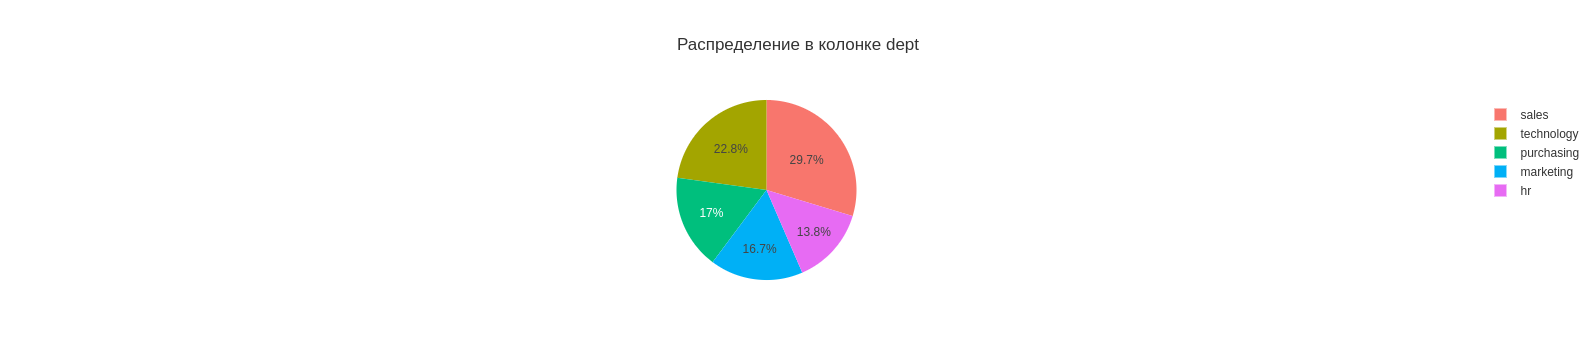

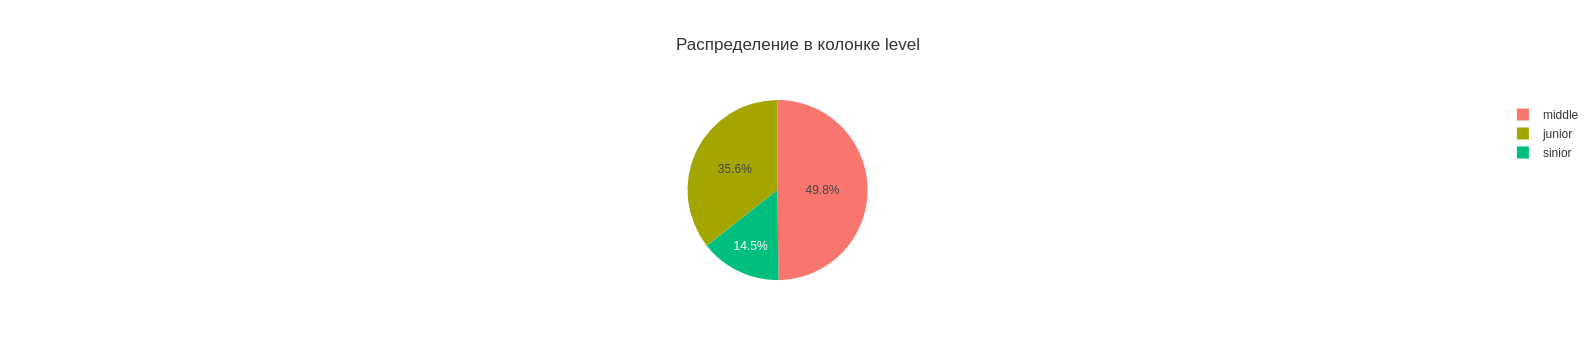

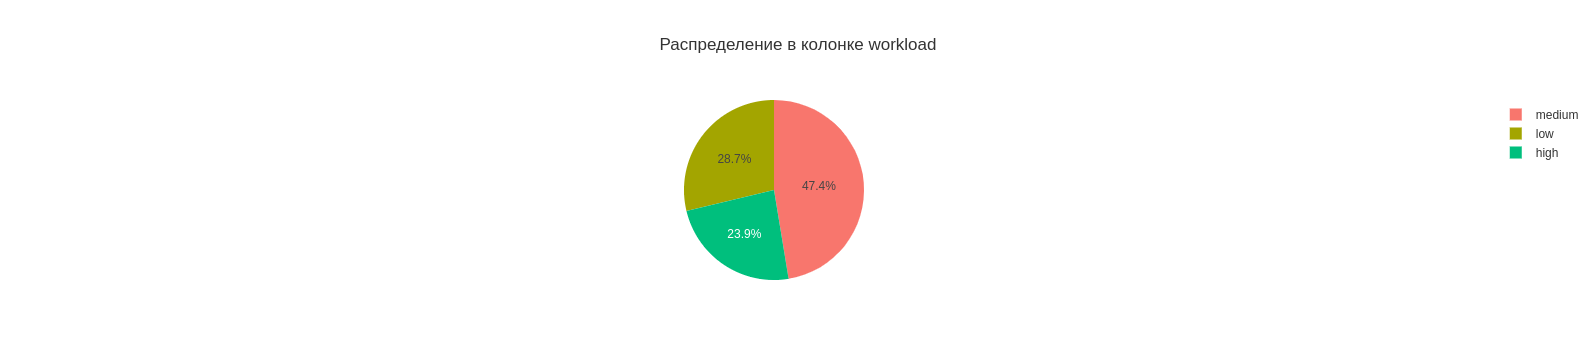

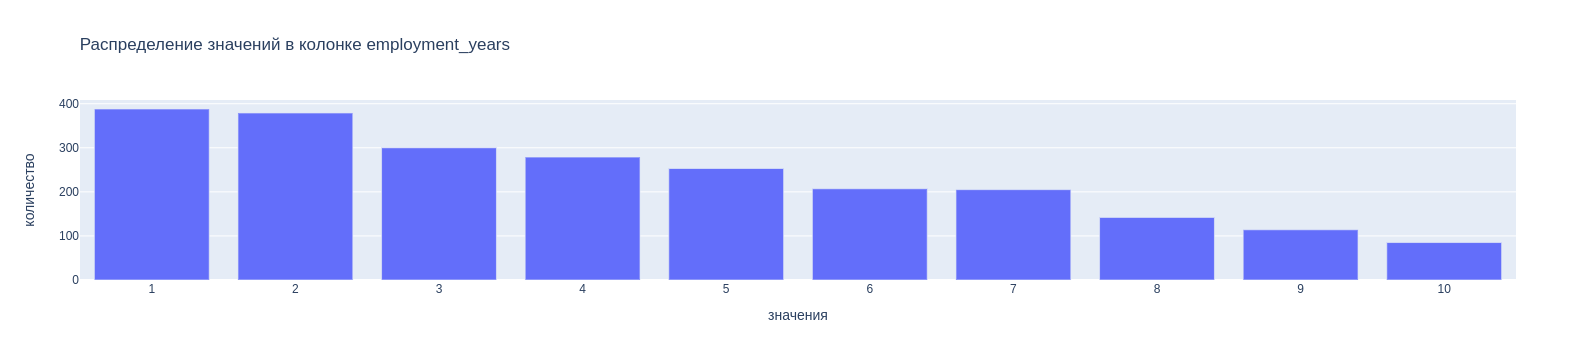

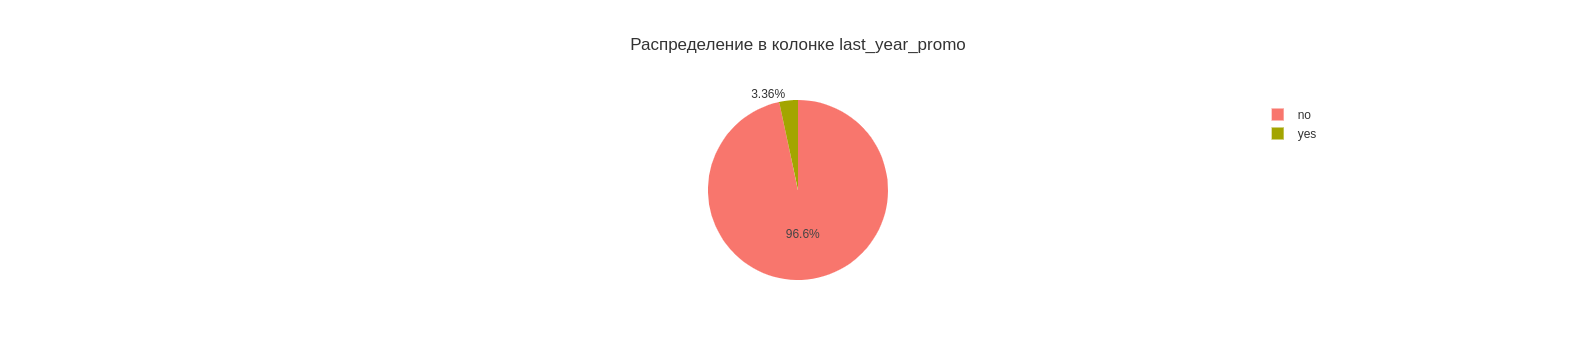

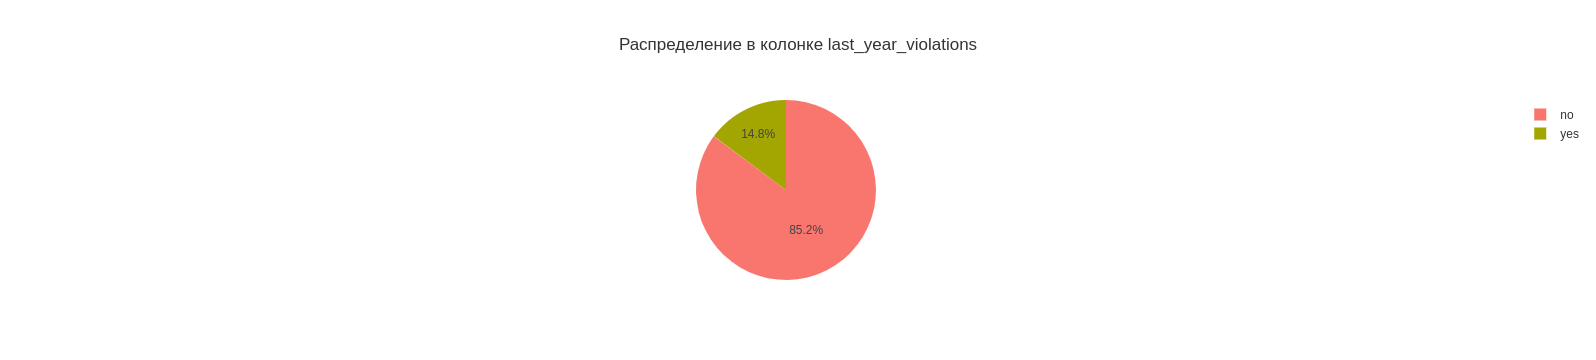

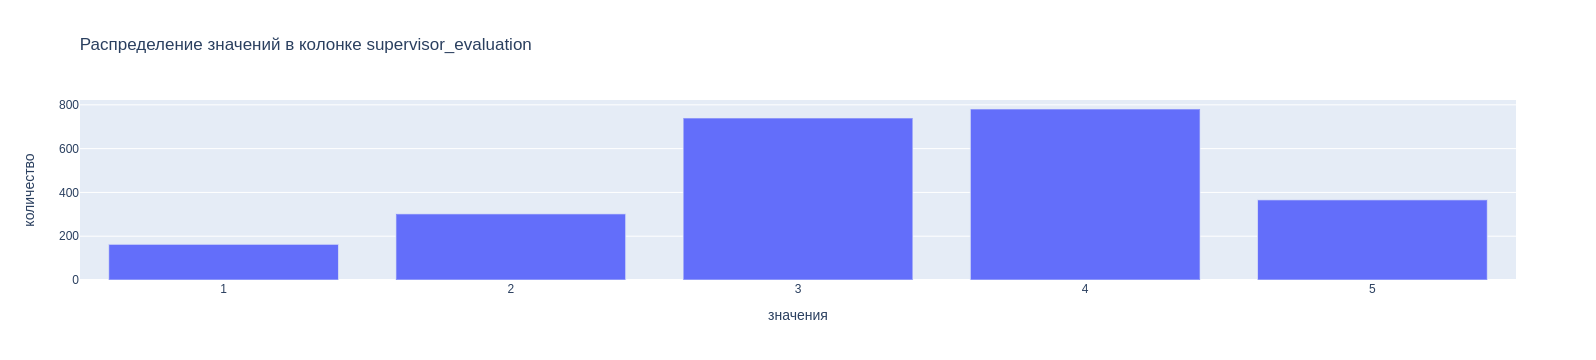

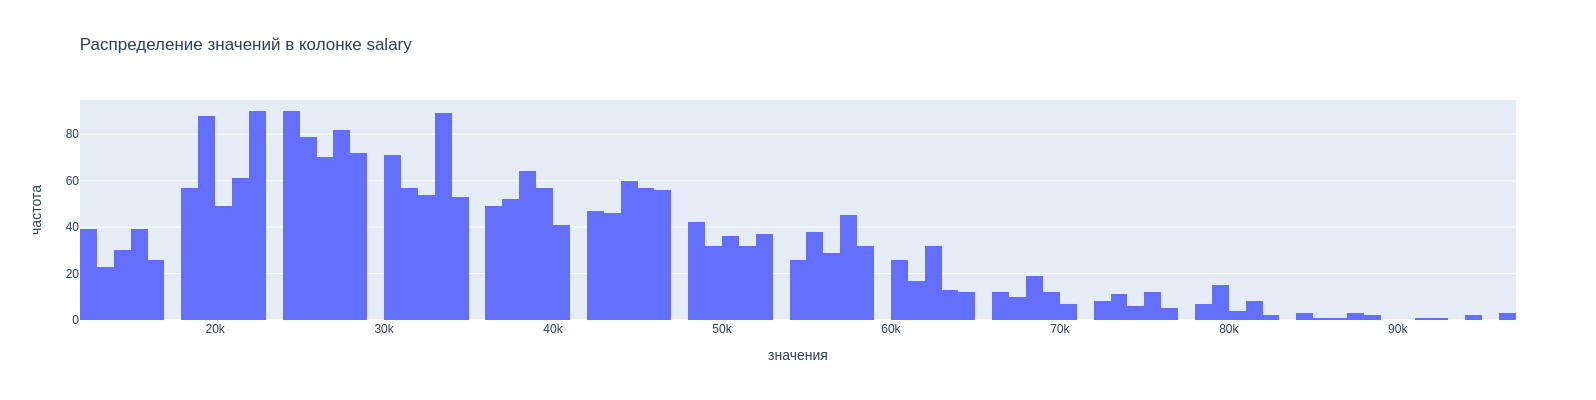

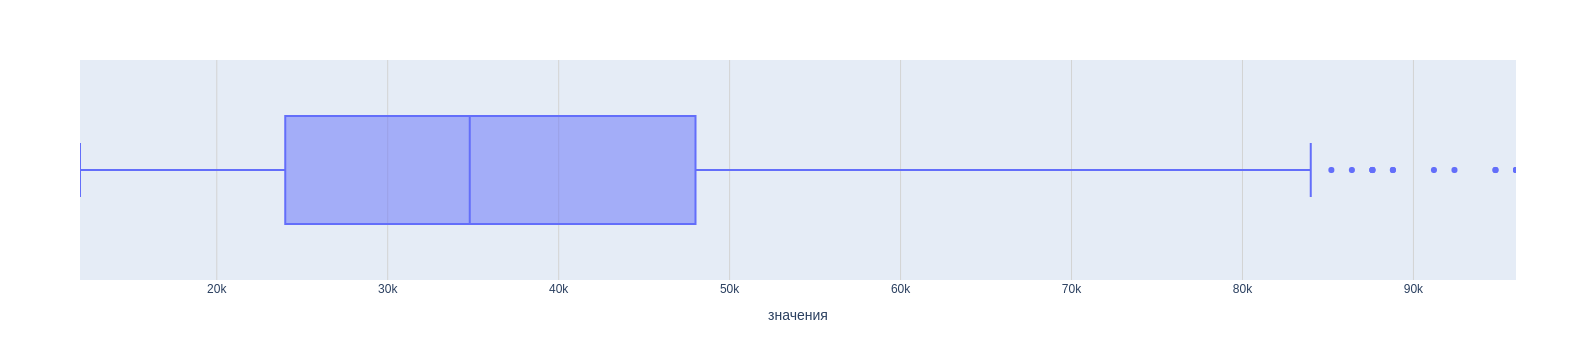

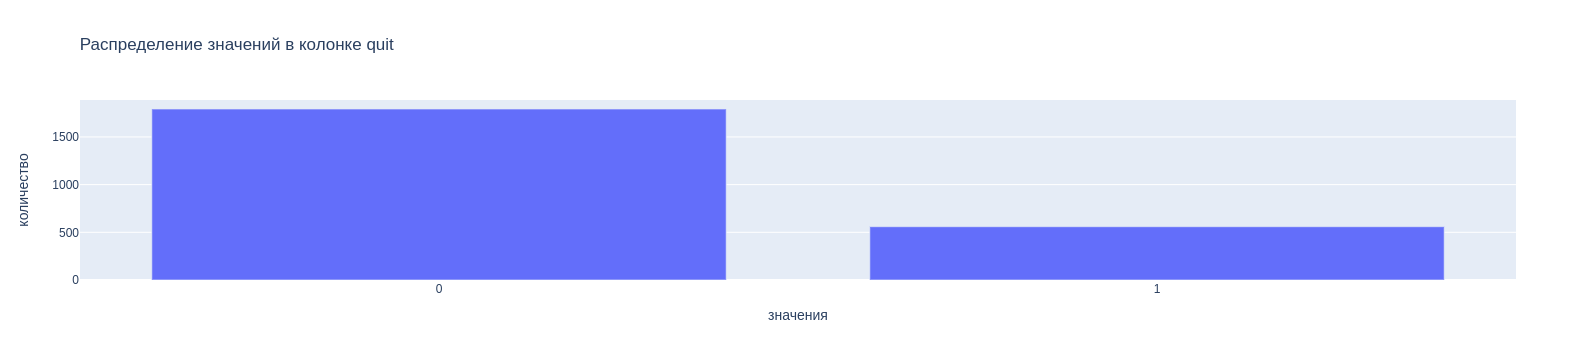

In [78]:
discrete_columns = ['employment_years', 'supervisor_evaluation', 'quit']


visualization_of_column(train_2, discrete_columns)

### Портрет уволившегося сотрудника

In [79]:
def visualization_2_df(data_1: pd.DataFrame, data_2: pd.DataFrame, discrete_columns : list[str]=None):
    """
    Функция для визуализации одной и той же колонки в двух таблицах в зависимости от типа
        - количественные типы - гистограмма, 
        - категориальные типы - круговая диаграмма. 

    Args: 
        data_1: первая таблица
        data_2: вторая таблица 
    """

    discrete_columns = set(discrete_columns if discrete_columns else [])

    numeric_columns = set(data_1.select_dtypes(include=['float64', 'int64']).columns)
    numeric_columns = numeric_columns - discrete_columns  

    categorical_columns = data_1.select_dtypes(include=['bool', 'object']).columns

    bins = 100


    for column in data_1.columns:
        if column in numeric_columns:
            fig = make_subplots(rows=1, cols=2, subplot_titles=['уволившиеся', 'не уволившиеся'])
            hist1 = px.histogram(
                data_1[column],
                nbins=bins,
                histnorm='probability density'
            )
            for trace in hist1.data:
                fig.add_trace(trace, row=1, col=1)
    
            hist2 = px.histogram(
                data_2[column],
                nbins=bins,
                histnorm='probability density'
            )
            for trace in hist2.data:
                fig.add_trace(trace, row=1, col=2)
            
            fig.update_layout(
                title=f'Распределение в колонке {column}',
                xaxis_title='значения',
                yaxis_title='плотность',
                xaxis2_title='значения',
                yaxis2_title='плотность',
                showlegend=False
            )
            fig.show()

            print("Медиана у уволившихся людей - {}, у не уволившихся - {}".format(data_1[column].median().round(2), data_2[column].median().round(2)))
        
        elif column in discrete_columns:

            value_counts_1 = data_1[column].value_counts()
            value_counts_2 = data_2[column].value_counts()

            
            fig = make_subplots(rows=1, cols=2, subplot_titles=['уволившиеся', 'не уволившиеся'])
            box1 = px.bar(
                    x=value_counts_1.index, 
                    y=value_counts_1
                )
            for trace in box1.data:
                fig.add_trace(trace, row=1, col=1)
    
            box2 = px.bar(
                    x=value_counts_2.index, 
                    y=value_counts_2
                )
            for trace in box2.data:
                fig.add_trace(trace, row=1, col=2)
            
            fig.update_layout(
                title=f'Распределение в колонке {column}',
                xaxis_title='значения',
                yaxis_title='количество',
                xaxis2_title='значения',
                yaxis2_title='количество',
                xaxis=dict(
                        tickmode='array',
                        tickvals=value_counts_1.index,
                        ticktext=value_counts_1.index
                    ),
                xaxis2=dict(
                        tickmode='array',
                        tickvals=value_counts_2.index,
                        ticktext=value_counts_2.index
                    ),
                showlegend=False
            )
            fig.show()
        
        elif column in categorical_columns:
            fig = make_subplots(
                rows=1, cols=2,
                specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                subplot_titles=['уволившиеся', 'не уволившиеся']
            )
            
            count_data_1 = data_1[column].value_counts().reset_index()
            count_data_1.columns = [column, 'count']
            
            pie1 = px.pie(
                count_data_1,
                names=column,
                values="count",
                template="ggplot2"
            )
            for trace in pie1.data:
                fig.add_trace(trace, row=1, col=1)
    
            count_data_2 = data_2[column].value_counts().reset_index()
            count_data_2.columns = [column, 'count']
    
            pie2 = px.pie(
                count_data_2,
                names=column,
                values="count",
                template="ggplot2"
            )
            for trace in pie2.data:
                fig.add_trace(trace, row=1, col=2)
            
    
            fig.update_layout(
                showlegend=True,
                title=f'Распределение в колонке {column}',
            )
            fig.update_traces(textfont_size=12, textposition='inside', textinfo='percent')
            
            fig.show()

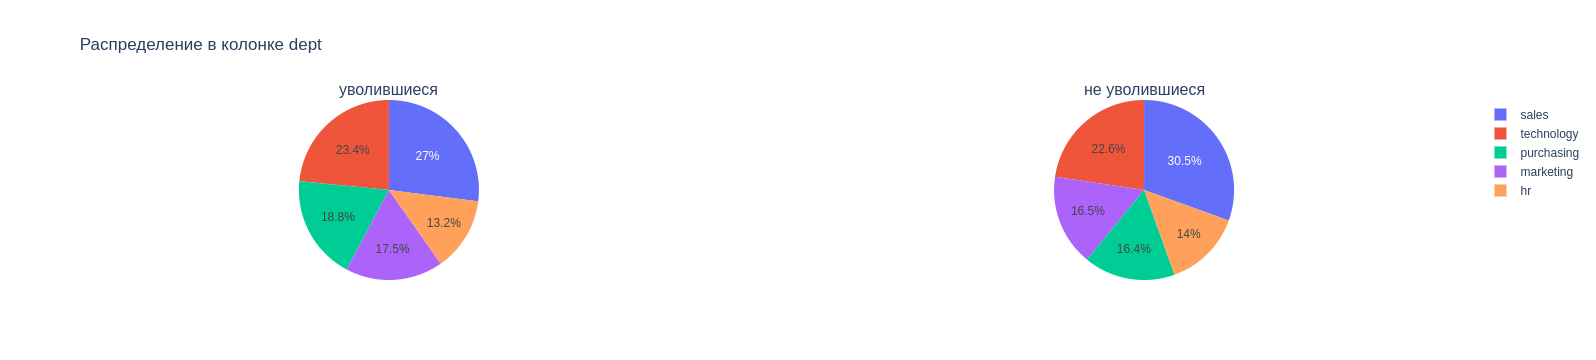

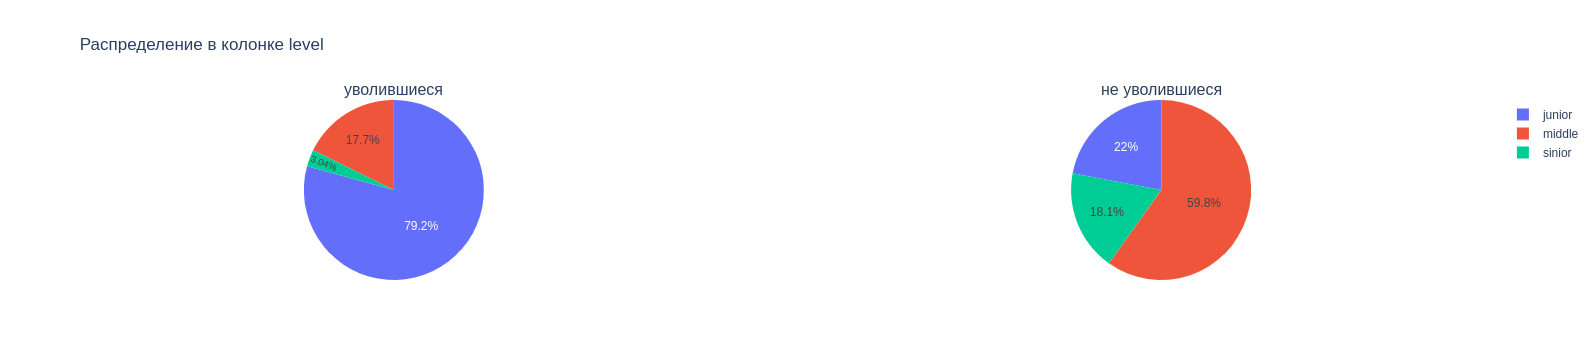

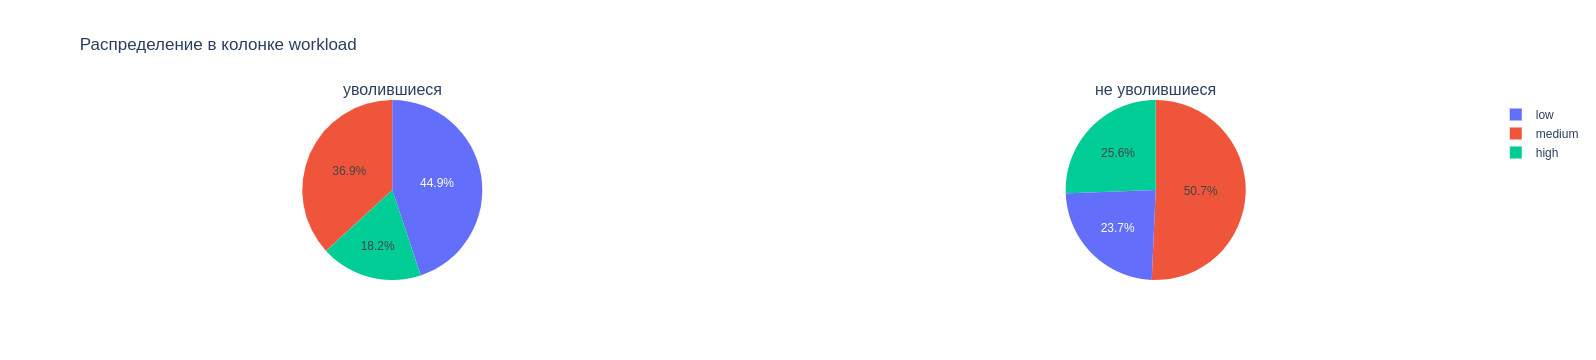

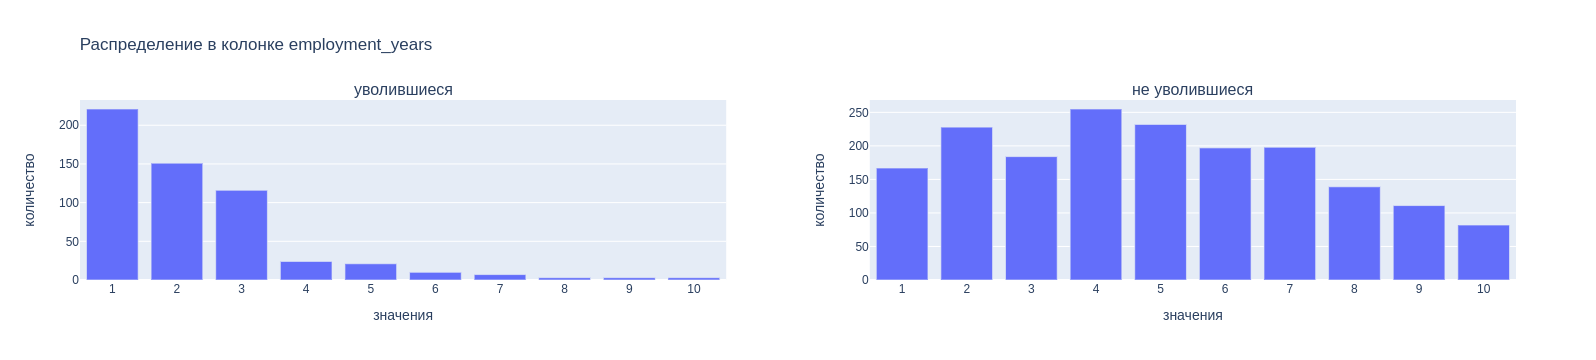

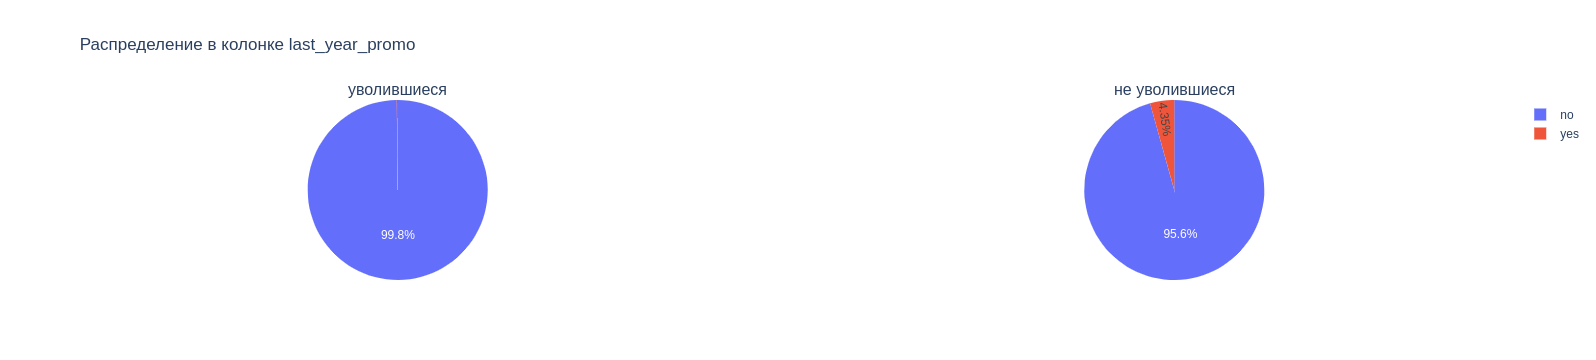

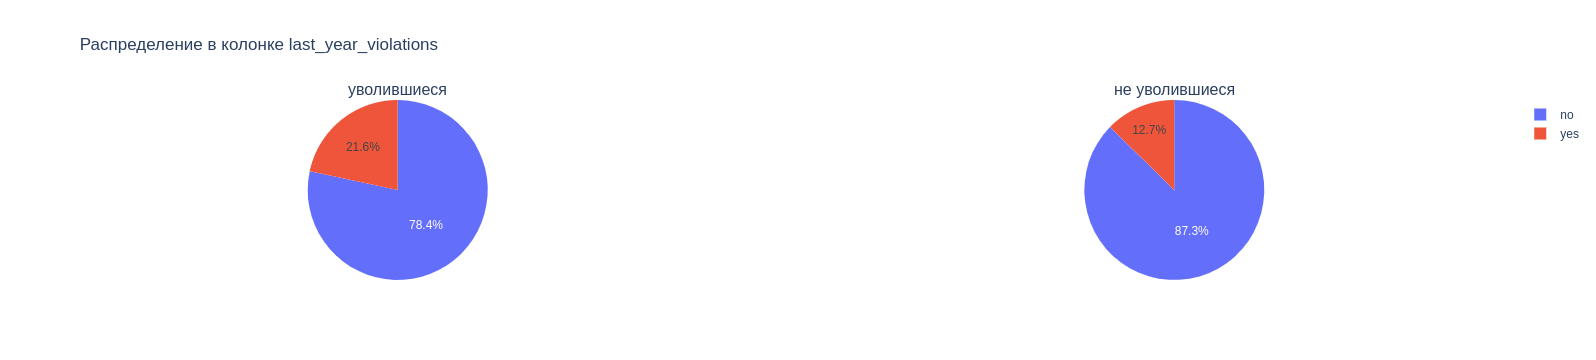

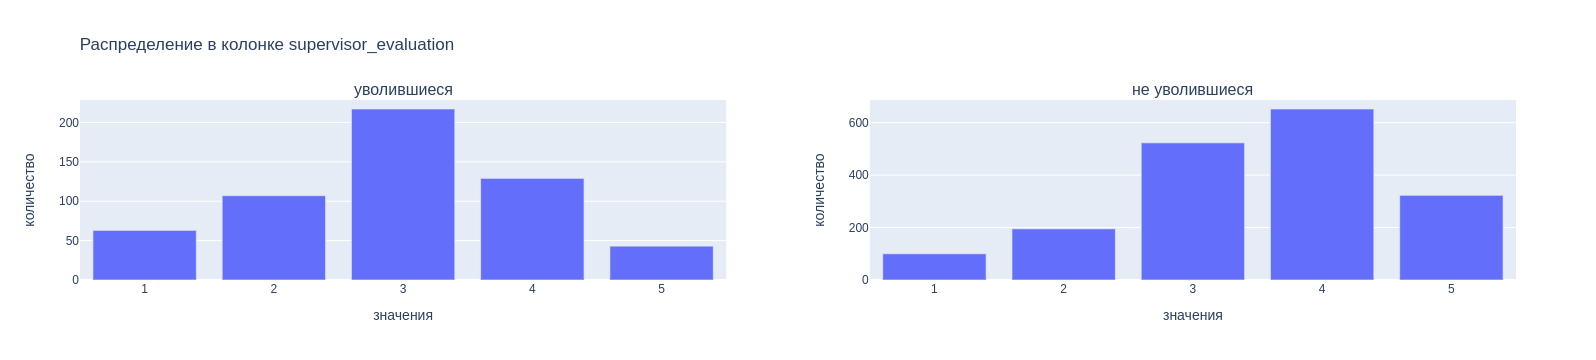

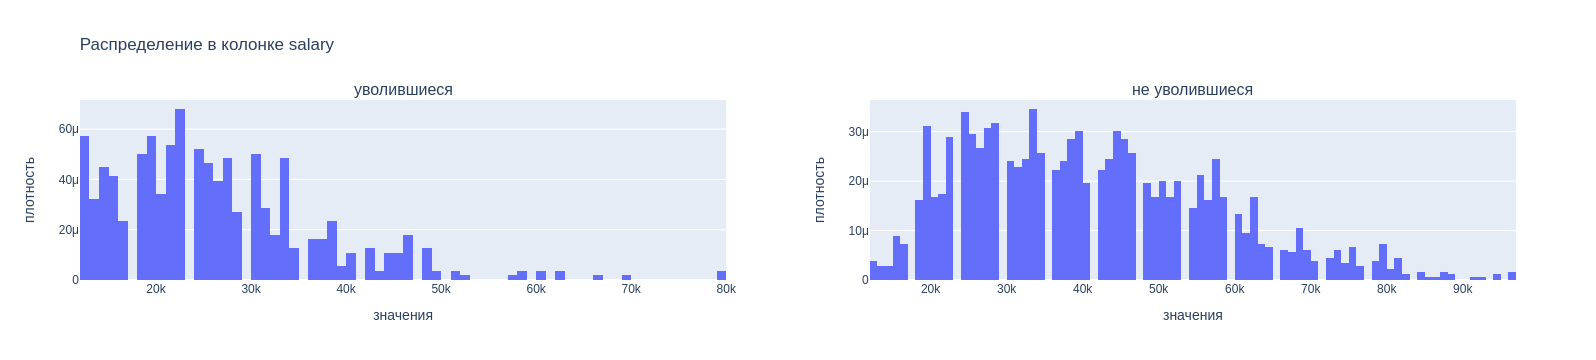

Медиана у уволившихся людей - 24000.0, у не уволившихся - 39600.0


In [80]:
discrete_columns = ['employment_years', 'supervisor_evaluation']

visualization_2_df(train_2.query('quit == 1').drop('quit', axis=1), train_2.query('quit == 0').drop('quit', axis=1), discrete_columns)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">


В большинстве своем, уволившийся сотрудник - это джуниор, с маленькой зарплатой, работающий меньше трех лет.

---

__Различия между штатными и уволившимися сотрудниками__

Признак `employment_years`:
    - Среднее значение у уволившихся людей болеее чем в два раза ниже, чем у штатных сотрудников. Так же у штатных струдников нормальное распределение этого признака, а у уволившихся сильно смещено влево.

Признак `supervisor_evaluation`:
    - У штатных сотрудников среднее значение этого признака выше. И график распределения смещен ближе к 5 баллам.

Признак `salary`:
    - Зарплата у уволившихся сотрудников гораздо меньше, чем у штатных, график распределения смещен левее.

Признак `dept`:
    - На графике значимой разници не наблюдается.

Признак `level`:
    - Тут видим явное преобладание оттоком сотрудников уровня junior. Это логично, так как это люди только пришедшие в индустрию имеющие мало опыто $\Rightarrow$ маленькая зарплата. Поэтому они всегда ищут способ повысить зарплату и уйти.

Признак `workload`:
    - На мой взгляд не сильно отличается распределение у штатных сотрудников и уволившихся.

Признак `last_year_promo`:
    - Все уволившиеся сотрудники имеют значение _no_ у этого параметра. Но и почти у всех штатных сотрудноков (94%) так же этот параметр равен  _no_.


Признак `last_year_violations`:
    - Распределени штатных сотрудников и уволившихся практически не отличается

</div>

### Проверка гипотезы

In [81]:
test_2['job_satisfaction_rate'] = grid.best_estimator_.predict(test_2.drop('quit', axis=1)).round(3)

/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



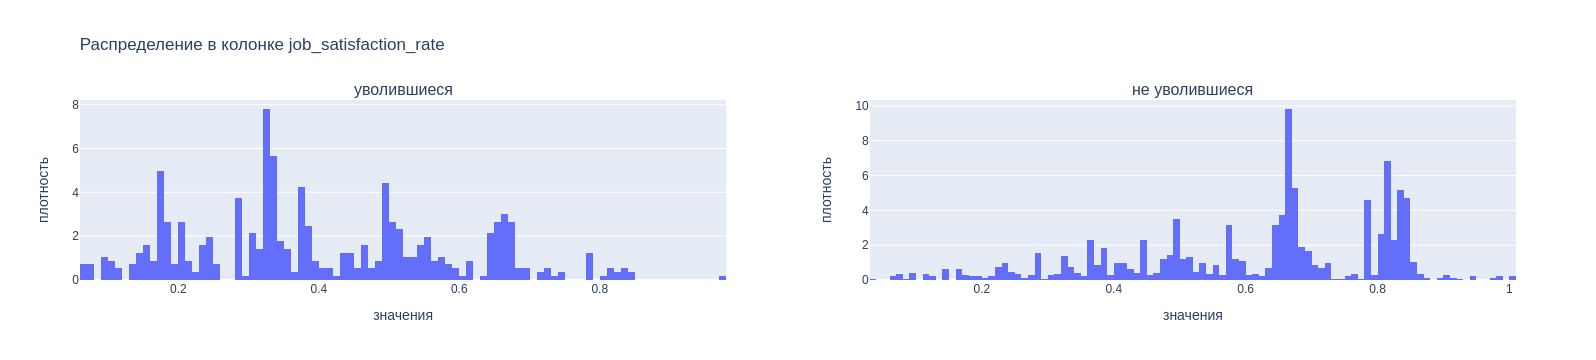

Медиана у уволившихся людей - 0.37, у не уволившихся - 0.66


In [82]:
visualization_2_df(test_2.query('quit == 1')[['job_satisfaction_rate']], test_2.query('quit == 0')[['job_satisfaction_rate']])

__Проверим статистически__

Сформулируем гипотезу:

$H_0:$ Среднее уровень удовлетворенности работой у уволившегося струдника, равен среднему уровню удовлетворенности у не уволившегося сотрудника.

$H_1:$ Среднее уровень удовлетворенности работой у уволившегося струдника меньше

Для проверки $H_0$ используем односторонний __t-тест__

In [83]:
result = st.ttest_ind(
    test_2.query('quit == 1')['job_satisfaction_rate'],
    test_2.query('quit == 0')['job_satisfaction_rate'],
    equal_var=False,
    alternative='less'
)

alpha = .05

print(f'p-value - {result.pvalue}')

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print("Не отвеграем нулевую гипотезу.")

p-value - 4.550491780490299e-91
Отвергаем нулевую гипотезу.


Отвергаем нулевую гипотезу. Средний уровень увовлетворенности работой у уволившихся меньше чем у штатных сотрудников.денег. Значит удовлетворенность работой может влиять на уход сотрудника из компании.

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод


В колонке `salary` наблюдается сильная разница между 75% и максимальным значением, что может говорить о выбросах.

Людей, у которых парамерт `last_year_promo` равено `True` всего 4 процента, но не будем удалять эту колонку из исследования, так как повышения за последний год может сильно влиять на удовлетворенность работой.

Примерно такая же ситуация с признаком `last_year_violations`, всего 14% имеют значение `True`


---

В большинстве своем, уволившийся сотрудник - это джуниор, с маленькой зарплатой, работающий меньше трех лет.

---

__Различия между штатными и уволившимися сотрудниками__

Признак `employment_years`:
    - Среднее значение у уволившихся людей болеее чем в два раза ниже, чем у штатных сотрудников. Так же у штатных струдников нормальное распределение этого признака, а у уволившихся сильно смещено влево.

Признак `supervisor_evaluation`:
    - У штатных сотрудников среднее значение этого признака выше. И график распределения смещен ближе к 5 баллам.

Признак `salary`:
    - Зарплата у уволившихся сотрудников гораздо меньше, чем у штатных, график распределения смещен левее.

Признак `dept`:
    - На графике значимой разници не наблюдается.

Признак `level`:
    - Тут видим явное преобладание оттоком сотрудников уровня junior. Это логично, так как это люди только пришедшие в индустрию имеющие мало опыто %\Rightarrow$ маленькая зарплата. Поэтому они всегда ищут способ повысить зарплату и уйти.

Признак `workload`:
    - На мой взгляд не сильно отличается распределение у штатных сотрудников и уволившихся.

Признак `last_year_promo`:
    - Все уволившиеся сотрудники имеют значение _no_ у этого параметра. Но и почти у всех штатных сотрудноков (94%) так же этот параметр равен  _no_.


Признак `last_year_violations`:
    - Распределени штатных сотрудников и уволившихся практически не отличается


---

На графике видно, что уровень удовлетворенности работой у штатных сотрудников гораздо выше.

Так же проверил статистически. Тест показал, что средний уровень увовлетворенности работой у уволившихся меньше чем у штатных сотрудников.денег. Значит удовлетворенность работой может влиять на уход сотрудника из компании.

Так что аналитики правы. удовлетворенность сотрудника работой в компании влияет на то, уволится ли сотрудник.


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_2)
    
</div>

## Добавление нового признака

In [84]:
# Добавим признак 'job_satisfaction_rate' предсказанный моделью из первой задачи

train_2['job_satisfaction_rate'] = grid.best_estimator_.predict(train_2.drop('quit', axis=1)).round(3)

## Корреляционный анализ 

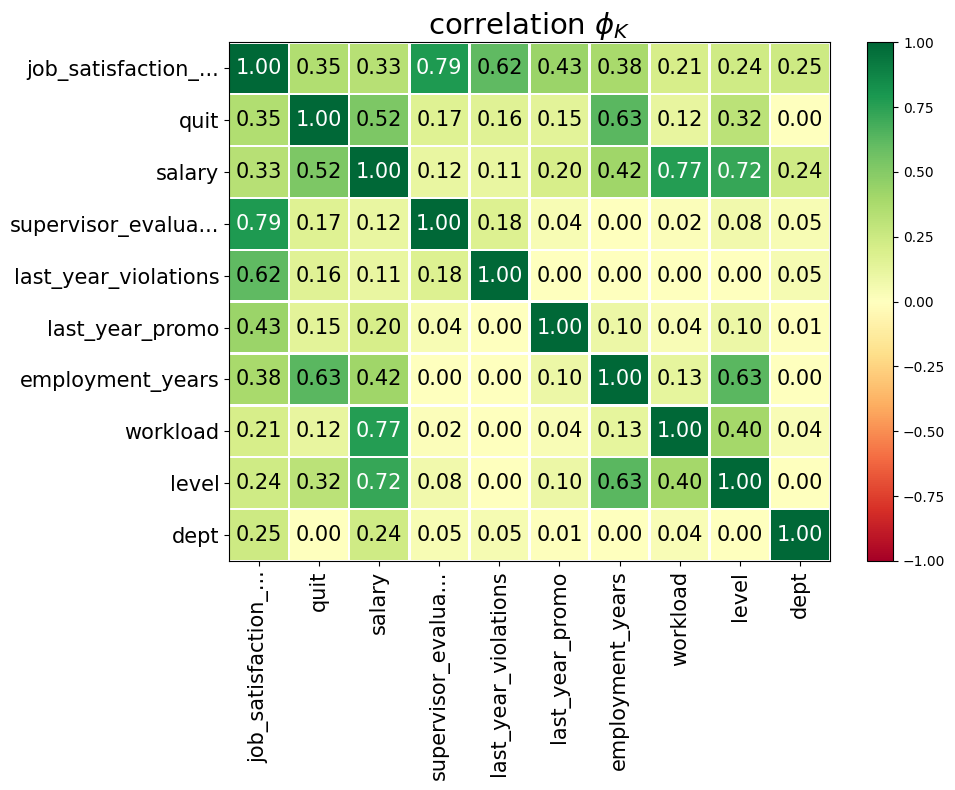

In [86]:
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = train_2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

Наблюдаем отсутствие мультиколлинеарности между признаками. 

Больше всего коэффициент корреляции у таргета и `employment_years`.

</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_2)
    
</div>

## Подготовка данных и поиск лучшей модели

In [87]:
train_features, train_target = train_2.drop('quit', axis=1), train_2['quit']
test_features, test_target = test_2.drop('quit', axis=1), test_2['quit']

Решил убрать признак `dept`, так коэффициент корреляции с таргетом у него равен нулю. Плюс пробовал обучать с ним, модели выдавали метрику меньше необходимого на тестовой выборке.

In [96]:
ohe_columns_2 = ['last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload']

num_columns_2 = [x for x in train_features.columns if train_features[x].dtypes != 'object']

ohe_pipe_2 = Pipeline([
    ('simple_imputer', SimpleImputer(
        missing_values=np.nan,
        strategy='most_frequent'
    )),
    ('ohe', OneHotEncoder(
        drop='first',
        handle_unknown='ignore'
    ))
])

ord_pipe_2 = Pipeline([
    ('simple_befor_imputer', SimpleImputer(
        missing_values=np.nan,
        strategy='most_frequent'
    )),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
        ],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan
    )),
    ('simple_after_imputer', SimpleImputer(
        missing_values=np.nan,
        strategy='most_frequent'
    )),
])

data_preprocessor_2 = ColumnTransformer([
    ('ohe', ohe_pipe_2, ohe_columns_2),
    ('ord', ord_pipe_2, ord_columns_2),
    ('num', MinMaxScaler(), num_columns_2)
])


pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=42))
])

param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(1, 20),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=42, max_iter=1000)],
        'models__solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=42, probability=True)],
        'models__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler()]
    }
]

grid_2 = GridSearchCV(
    pipe_final_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_2.fit(train_features, train_target)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/boraplyton/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/boraplyton/anaconda3/envs/practicum/li

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simple_befor_imputer',
                                                                                          SimpleImputer(strategy=...
                         {'models': [LogisticRegression(max_iter=1000,
                                                        random_state=42)],
                          'models__solver': ['lbfgs', 'liblinear', 'sag',
                                             'newton-cg'],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__kernel': ['linear', 'poly', 'rbf',
                                             'sigmoid'],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler()]}],
             scoring='roc_auc', verbose=1)

In [97]:
pred_2 = grid_2.best_estimator_.predict_proba(test_features)[:, 1]

roc_auc_2 = roc_auc_score(test_target, pred_2).round(4)

print(f'ROC_AUC: на тестовой выборке: {roc_auc_2}')

ROC_AUC: на тестовой выборке: 0.9143


Хорошее значение метрики, оставляем эту модель

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод


Для поиска лучшей модели была выбрана метрика __ROC_AUC__.

Удалил из обучения признак `dept`, так как коэффициент корреляции с таргетом равен нулю.

Признаки `last_year_promo`,  `last_year_violations` закодировал __OHE__, признаки `level`, `workload` закодировал __ORD__.

Поиск лучшей модели и ее гиперпараметры осуществлял с помошью пайплайна. Перебрал 3 модели и их гиперпараметры:

1. DecisionTreeClassifier.
    - перебирал гиперпараметр - max_depth от 0 до 20

2. LogisticRegression.
    - перебирал гиперпараметр - solver \['lbfgs', 'liblinear', 'sag', 'newton-cg'\]
3. Lasso.
    - перебирал гиперпараметр - kernel \['linear', 'poly', 'rbf', 'sigmoid'\]

Для каждой модели пребирал раззные способы масштабирования: __StandardScaler__ и __MinMaxScaler__


---

Лучшей моделью оказалось __SVC__ с ядром `poly`. Метрика __ROC_AUC__ на тестовой выборке: 0.9143, это больше чем нужно, поэтому оставляем эту модель.


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План)
    
</div>

## Анализ важности признаков

In [98]:
ohe_features = grid_2.best_estimator_.named_steps['preprocessor']['ohe'].get_feature_names_out(ohe_columns_2)
ord_features = grid_2.best_estimator_.named_steps['preprocessor']['ord'].get_feature_names_out(ord_columns_2)
num_features = num_columns_2
feature_names = list(ohe_features)  + list(ord_features) + num_features

X_test_transform = pd.DataFrame(grid_2.best_estimator_.named_steps['preprocessor'].transform(test_features), columns=feature_names)

X_background = shap.sample(X_test_transform, 100)  # Берем только 100 объектов

explainer = shap.KernelExplainer(grid_2.best_estimator_[1].predict, X_background)
shap_values = explainer(X_test_transform)

  0%|          | 0/2000 [00:00<?, ?it/s]

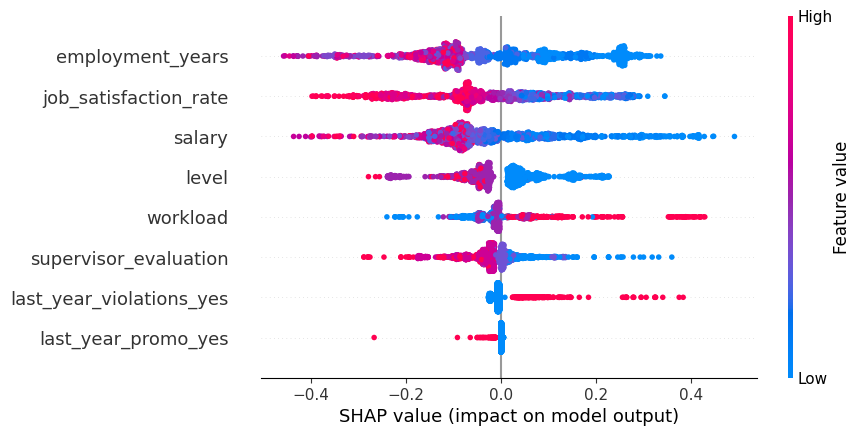

In [99]:
shap.plots.beeswarm(shap_values, max_display=None)

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

### Вывод

По графику важности признаков видим что:

Сильнее всего на результат модели влияют: `employment_years`, `job_satisfactiom_rate`, `salary` и `level`.

- При высоких значениях `employment_years` вероятность увольнения ниже, при низких значениях соответственно выше.
- аналогичная ситуация с `job_satisfactiom_rate`, `salary` и `level`.


</div>

<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h3 style="margin-top: 0; margin-bottom: 10px;">Навигация</h3> 



[Перейти к плану](#План_2)
    
</div>

## Вывод по задаче 2

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">


В ходе анализа данных были выявлены и удалены дублирующиеся записи. Мультиколлинеарности между признаками обнаружено не было. Пропущенные значения заполнил модой.

Модель обучалась без признака `dept`, так как у него нулевой коэффициент корреляции. Так же проведя анализ (обучив модели с этим параметром, я пришел к тому, что метрики с этим параметром были ниже).

Лучшей моделью оказалось __SVC__ с ядром `poly`. Метрика __ROC_AUC__ на тестовой выборке: 0.9143, это больше чем нужно, поэтому оставляем эту модель.

В ходе интерпретации модели было выяснено следующее:

Сильнее всего на результат модели влияют: `employment_years`, `job_satisfactiom_rate`, `salary` и `level`.

- При высоких значениях `employment_years` вероятность увольнения ниже, при низких значениях соответственно выше.
- аналогичная ситуация с `job_satisfactiom_rate`, `salary` и `level`.

</div>

# Общий вывод

<div style="border: 2px solid black; padding: 10px; border-radius: 5px;">

__Задача__

Передо мной стояли две задачи. В ходе исследования я успешно справился с ними.

1. Построить модель, которая будет предсказывать уровень удовлетворенности сотрудника на основе данных заказчика.
2. Построить модель, которая сможет предсказать то, что сотрудник уволится из кампании.


---

---

__Предоставленные данные:__

Заказчик представил следующие данные.

Таблицы __train_job_satisfacrion_rate__ и __test_features__ содержита информацию о характеристиках сотрудников кампании.

В таблице __train_job_satisfacrion_rate__ 4000 записей и 9 колонок
В таблице __test_features__ 2000 записей и 8 параметров

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак. (отсутствует в таблице __test_features__)


Таблица __test_target_job_satisfaction_rate__ содержит информацию о целевом признаке тестовой выборки 
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак. Для ворой задачи таблица называлась __test_quit__


---

---

__Предобработка__


Для первой задачи предобработка была следующая:

- Объеденил две таблицы тестовой выборки в одну для удобства в дальнейшем.
- Проверил названия колонок. Все соответствуют стандартам.
- Проверил на дубликаты и удалил повторяющиеся записи.
- Проверил на попадание тренировочных данных в тестовую выборку. Ничего не обнаружено.
- Обнаружил пропущенные значения в тренировочной и тестовой выборке. Обработаю их в пайплайне.

--- 

Для второй задачи:

- Объеденил две таблицы тестовой выборки в одну для удобства в дальнейшем.
- Проверил названия колонок. Все соответствуют стандартам.
- Проверил на дубликаты и удалил повторяющиеся записи.
- Проверил на попадание тренировочных данных в тестовую выборку. Ничего не обнаружено.
- Обнаружил пропущенные значения тестовой выборке. Обработаю их в пайплайне.
- Закодировал таргет в тренировочной и тестовой выборках


---

---

__Модель МО__

__Первая задача:__

Лучшей моделью оказалось DecisionTreeRegression. С гиперпараметром max_depth = 13. Для оценки моделей выбрана метрика __SMAPE__. На тестовой выборке ее значение оказалось равным 14.62.

В ходе интерпретации модели было выяснено следующее:

Сильнее всего на результат модели влияют: `supervisor_evaluation`, `employment_years`, `level` и  `salary`

- При высоких значениях `supervisor_evaluation` уровень удовлетворенности сотрудника выше, при низких значениях соответственно ниже.
- аналогичная ситуация с `employment_years`
- Чем ниже должность (`level`), тем уровень удовлетворенности выше.
- Чем выше зарплата (`salary`), тем уровень удовлетворенности выше.

--- 


__Вторая задача__

Модель обучалась без признака `dept`, так как у него нулевой коэффициент корреляции. Так же проведя анализ (обучив модели с этим параметром, я пришел к тому, что метрики с этим параметром были ниже).

Лучшей моделью оказалось __SVC__ с ядром `poly`. Метрика __ROC_AUC__ на тестовой выборке: 0.9143, это больше чем нужно, поэтому оставляем эту модель.

В ходе интерпретации модели было выяснено следующее:

Сильнее всего на результат модели влияют: `employment_years`, `job_satisfactiom_rate`, `salary` и `level`.

- При высоких значениях `employment_years` вероятность увольнения ниже, при низких значениях соответственно выше.
- аналогичная ситуация с `job_satisfactiom_rate`, `salary` и `level`.


---

---

__Результат__


В ходе исследования были проанализированы уволившиеся и штатные сотрудники. Так же создан портрет уволившегося сотрудника:  уволившийся сотрудник - это джуниор, с маленькой зарплатой, работающий меньше трех лет.


__Различия между штатными и уволившимися сотрудниками__

Признак `employment_years`:
    - Среднее значение у уволившихся людей болеее чем в два раза ниже, чем у штатных сотрудников. Так же у штатных струдников нормальное распределение этого признака, а у уволившихся сильно смещено влево.

Признак `supervisor_evaluation`:
    - У штатных сотрудников среднее значение этого признака выше. И график распределения смещен ближе к 5 баллам.

Признак `salary`:
    - Зарплата у уволившихся сотрудников гораздо меньше, чем у штатных, график распределения смещен левее.

Признак `dept`:
    - На графике значимой разници не наблюдается.

Признак `level`:
    - Тут видим явное преобладание оттоком сотрудников уровня junior. Это логично, так как это люди только пришедшие в индустрию имеющие мало опыто %\Rightarrow$ маленькая зарплата. Поэтому они всегда ищут способ повысить зарплату и уйти.

Признак `workload`:
    - На мой взгляд не сильно отличается распределение у штатных сотрудников и уволившихся.

Признак `last_year_promo`:
    - Все уволившиеся сотрудники имеют значение _no_ у этого параметра. Но и почти у всех штатных сотрудноков (94%) так же этот параметр равен  _no_.


Признак `last_year_violations`:
    - Распределени штатных сотрудников и уволившихся практически не отличается


---

Уровень удовлетворенности работой у штатных сотрудников гораздо выше.

Так что аналитики правы. удовлетворенность сотрудника работой в компании влияет на то, уволится ли сотрудник.


---

---

__Рекомендации__

При наборе сотрудников на работу (особенно уровня джуниор) стоит повышать их мотивированность. Так же стоит чаще пересматривать их зарплату. Так как ее уровень влияет на отток кадров. Так же стоит повышать лояльность сотрудников на работе, чем дольше они работают, тем меньше шанс, что они уволятся.

</div>


<div style="background-color: #B8F0D6; padding: 20px; border: 1px solid #192C57;">
    <h2 style="margin-top: 0; margin-bottom: 10px;">Навигация</h2> 



[Перейти к плану](#План_2)
    
</div>